In [5]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.simulations.swissroll import get_swiss_roll_data, get_swiss_roll_gradients_noy_norotate, get_swiss_roll_gradients_noy
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.utils.replicates import Replicate
from montlake.statistics.normalization import normalize_L212
from montlake.gradients.estimate import get_grads_pullback
from megaman.embedding import LTSA
from megaman.embedding import Isomap
from megaman.embedding import SpectralEmbedding
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
from montlake.plotting.plotting import plot_reg_path_ax_lambdasearch_customcolors_names

In [2]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.00, rotate = False, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [3]:
n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


In [4]:
nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy_norotate(ts[replicates[r].selected_points[i]], b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    

In [5]:
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


initializing lambda search
converged 10.024246031311847
0 5.0121230156559236 probe
converged 5.0121230156559236
1 2.5060615078279618 probe
converged 2.5060615078279618
2 1.2530307539139809 probe
converged 1.2530307539139809
3 0.6265153769569904 probe
converged 0.6265153769569904
4 0.3132576884784952 probe
converged 0.3132576884784952
5 0.1566288442392476 probe
6 0.23494326635887142 probe
converged 0.23494326635887142
7 0.1957860552990595 probe
converged 0.1957860552990595
8 0.17620744976915356 probe
converged 0.17620744976915356
9 0.1664181470042006 probe
converged 0.1664181470042006
10 0.1615234956217241 probe
converged 0.1615234956217241
11 0.15907616993048584 probe
converged 0.15907616993048584
12 0.15785250708486673 probe
converged 0.15785250708486673
13 0.15724067566205718 probe
converged 0.15724067566205718
14 0.1569347599506524 probe
converged 0.1569347599506524
15 0.15678180209495002 probe
converged 0.15678180209495002
16 0.15670532316709881 probe
converged 0.15670532316709881


In [6]:
rep = replicates[r]

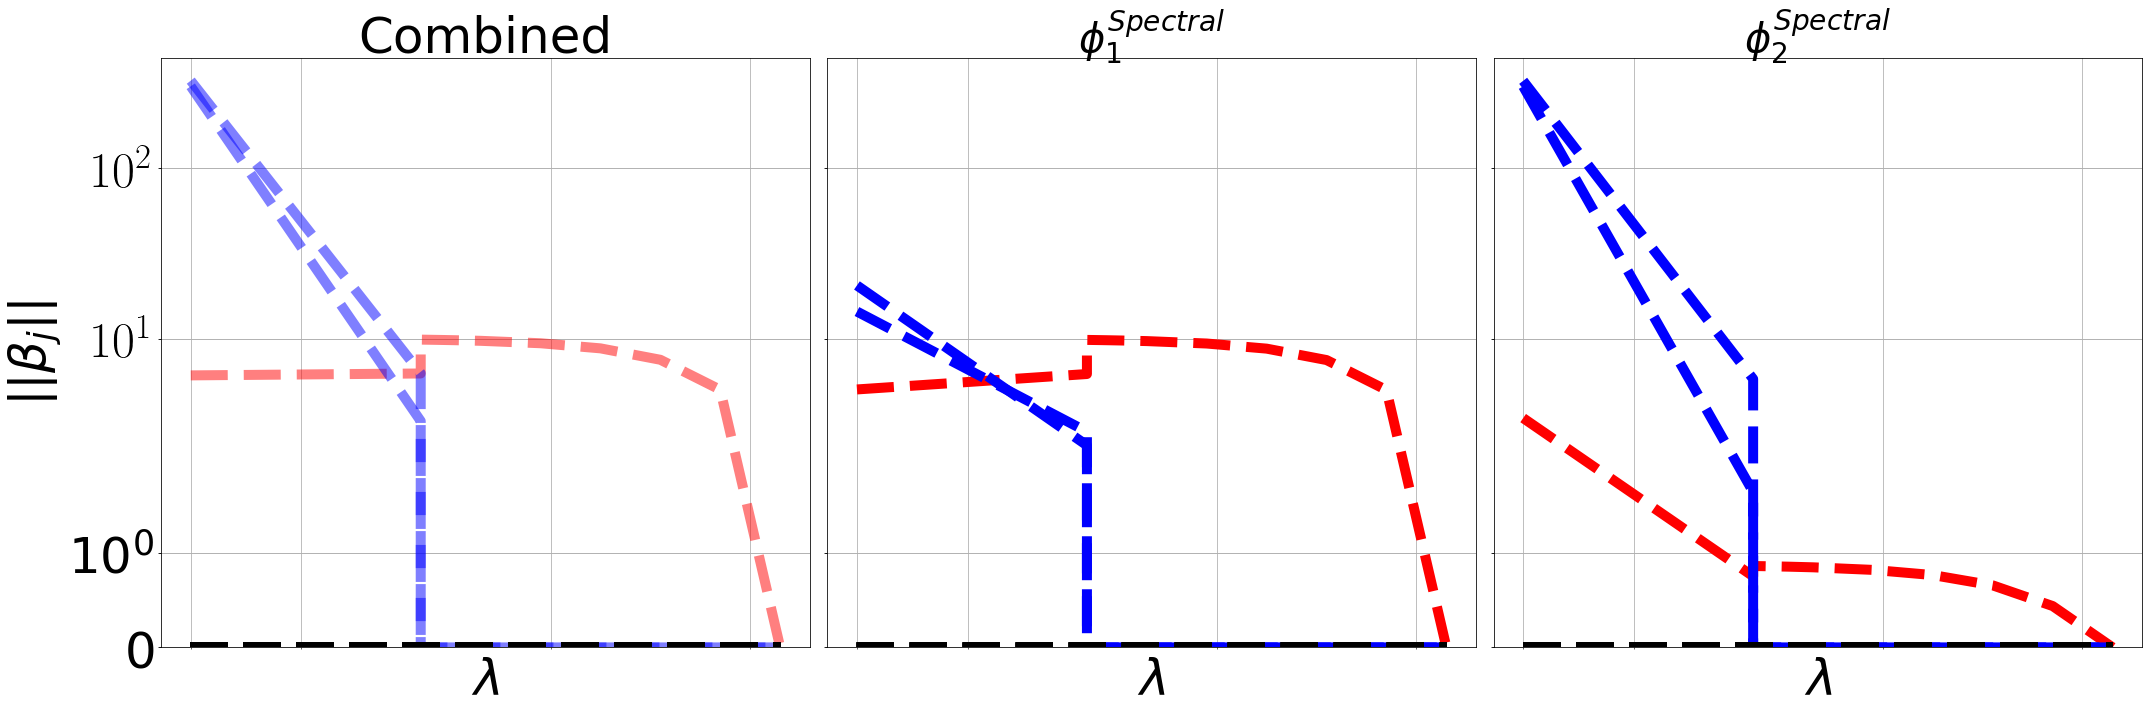

In [7]:

m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',48)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [8]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.001, rotate = False, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy_norotate(ts[replicates[r].selected_points[i]], b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    
#from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


initializing lambda search
converged 9.959148133612407
0 4.979574066806204 probe
converged 4.979574066806204
1 2.489787033403102 probe
converged 2.489787033403102
2 1.244893516701551 probe
converged 1.244893516701551
3 0.6224467583507755 probe
converged 0.6224467583507755
4 0.3112233791753877 probe
converged 0.3112233791753877
5 0.15561168958769386 probe
converged 0.15561168958769386
6 0.07780584479384693 probe
7 0.11670876719077039 probe
8 0.13616022838923214 probe
converged 0.13616022838923214
9 0.12643449779000127 probe
10 0.1312973630896167 probe
11 0.13372879573942442 probe
we did it [0 2]


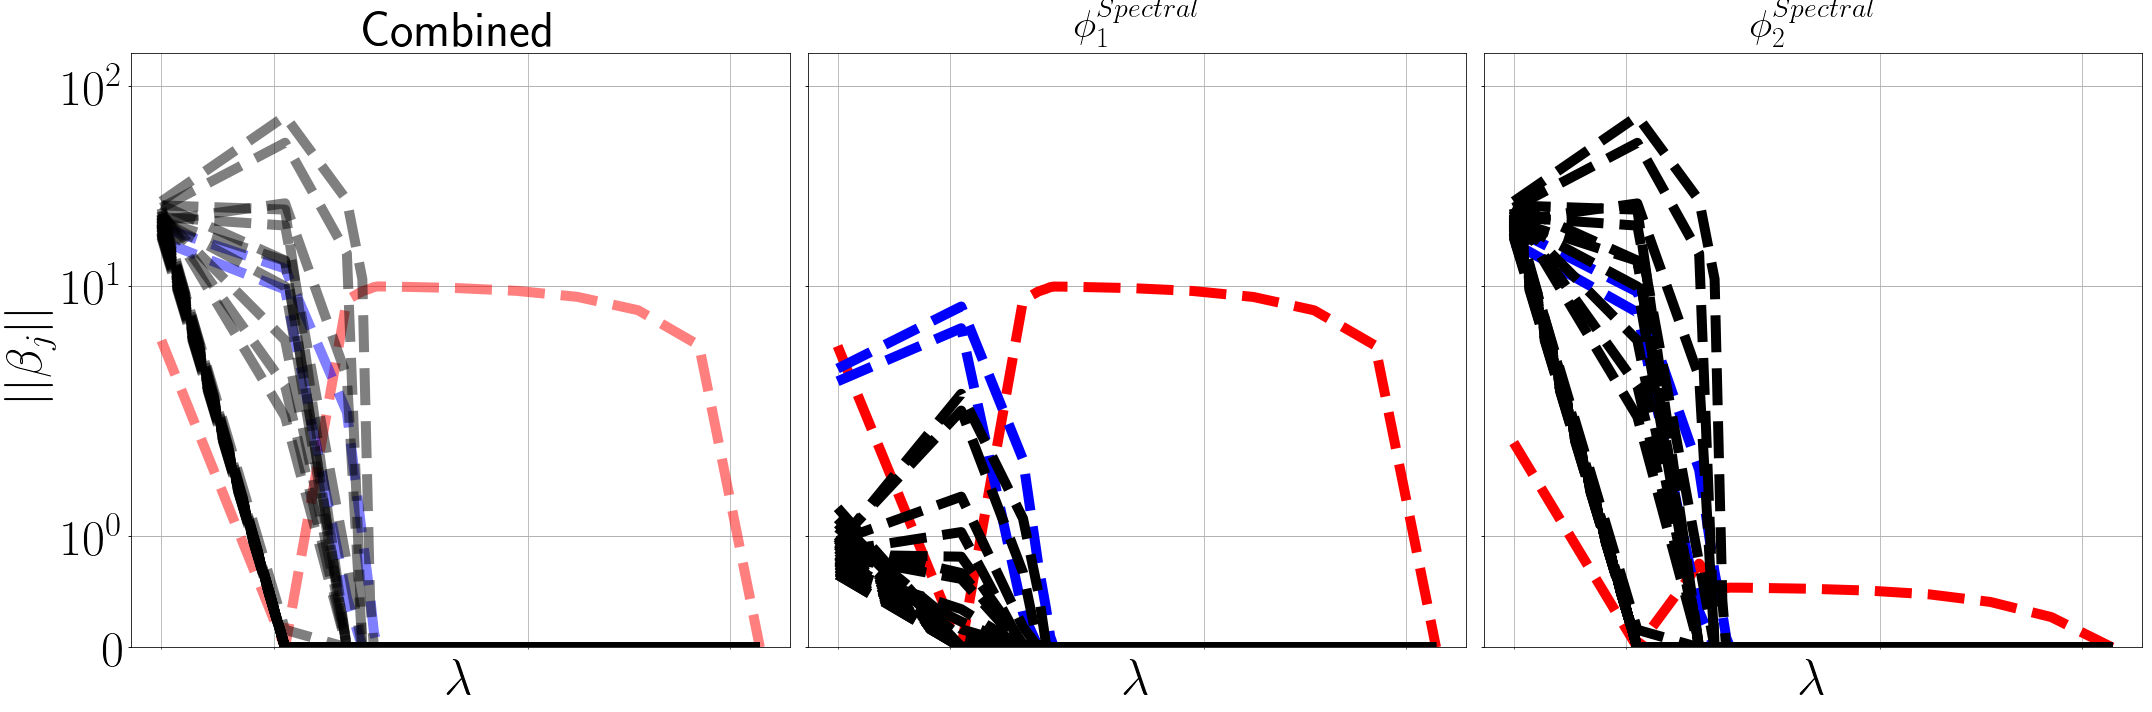

In [9]:
m = 2
colors = np.hstack([np.repeat('red',1), np.repeat('blue',2),np.repeat('black',48)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [2]:
data, rotator, ts, ys = get_swiss_roll_data(n = 10000, theta =np.pi / 4,xvar = 0.00, rotate = True, b = 49)
radius = 1.88
n_neighbors = 100
geom = get_geom(data, radius, n_neighbors)  

n_components = 2
b = 49
d = 2
spectral_embedding = SpectralEmbedding(n_components=n_components,eigen_solver='arpack',geom=geom)
embed_spectral = spectral_embedding.fit_transform(data)

nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator,b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    
#from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
gl_itermax = 500
r = 0
max_search = 30
reg_l2 = 0.
tol = 1e-14
learning_rate = 100
replicates[r].results = get_sr_lambda_parallel(replicates[r].dphispectral_M_normalized , replicates[r].dg_M, gl_itermax,reg_l2, max_search, d, tol,learning_rate)


/Users/samsonkoelle/miniconda3/envs/manifold_env_april/lib/python3.5/site-packages/sklearn/utils/validation.py:457: DeprecationWarning: Passing 'None' to parameter 'accept_sparse' in methods check_array and check_X_y is deprecated in version 0.19 and will be removed in 0.21. Use 'accept_sparse=False'  instead.
  " instead.", DeprecationWarning)


initializing lambda search
converged 9.99825134068535
0 4.999125670342675 probe
converged 4.999125670342675
1 2.4995628351713375 probe
converged 2.4995628351713375
we did it [ 0 38]


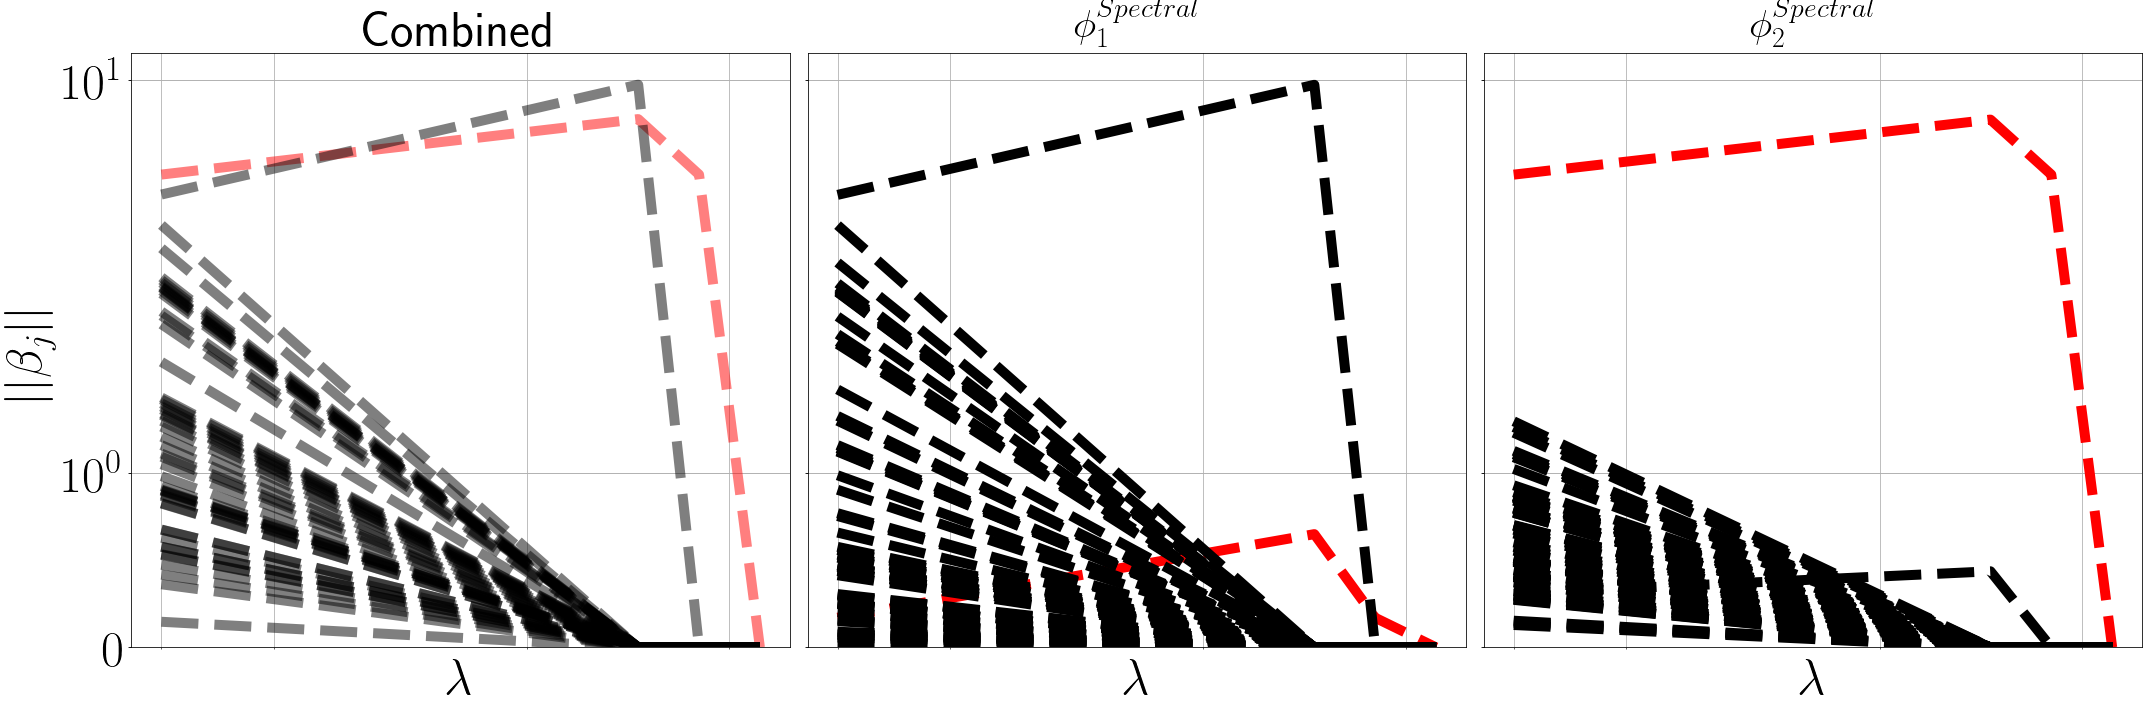

In [8]:
m = 2
import matplotlib
colors = np.hstack([np.repeat('red',1),np.repeat('black',49)])
replicates[r].get_ordered_axes()

%matplotlib inline
matplotlib.rc('font', family='sans-serif')
fig, axes_all = plt.subplots(1,3, figsize=(30,10) )
names = [r'$\phi_1^{Spectral}$', r'$\phi_2^{Spectral}$']
plot_reg_path_ax_lambdasearch_customcolors_names(axes_all, replicates[0].cs_reorder, replicates[0].xaxis_reorder * np.sqrt(m * nsel), fig,colors, names)
#axes_all[2].legend('off')
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/sr_internal_mflasso', bbox_inches = "tight")

In [7]:
replicates[0].dg_M.shape

(100, 2, 50)

In [22]:
np.linalg.norm(replicates[0].dg_M , axis = tuple([0,1])).shape

(49,)

In [24]:
np.linalg.norm(replicates[0].dg_x_normalized , axis = tuple([0,1]))

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [ ]:
nreps = 1
nsel = 100 
replicates = {}
embedding = embed_spectral
for r in range(nreps):
    #print(i)
    replicates[r] = Replicate(nsel = nsel, n = 10000)
    replicates[r].tangent_bases_M = get_wlpca_tangent_sel(data, geom, replicates[r].selected_points, d)
    replicates[r].tangent_bases_phi = get_rm_tangent_sel(embedding, geom, replicates[r].selected_points, d)
    #replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy(ts[replicates[r].selected_points[i]], rotator, b) for i in range(nsel)])
    replicates[r].dg_x = np.asarray([get_swiss_roll_gradients_noy_norotate(ts[replicates[r].selected_points[i]], b) for i in range(nsel)])
    replicates[r].dg_x_normalized = normalize_L212(replicates[r].dg_x)
    replicates[r].dg_M = np.einsum('i b p, i b d -> i d p', replicates[r].dg_x_normalized, replicates[r].tangent_bases_M)
    replicates[r].dphispectral_M = get_grads_pullback(data,  embedding, geom, replicates[r].tangent_bases_M, replicates[r].tangent_bases_phi, replicates[r].selected_points)
    replicates[r].dphispectral_M_normalized = normalize_L212(replicates[r].dphispectral_M)
    

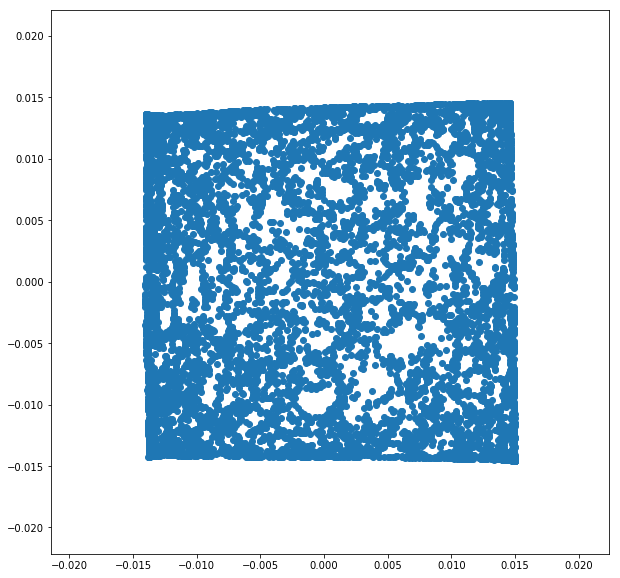

In [18]:
%matplotlib inline
embedding = embed_spectral
fig, axes_all = plt.subplots(figsize=(10,10) )
axes_all.scatter(embedding[:,0],embedding[:,1])#, s = 10, alpha = 1, c = swiss_internal[inds1,0], cmap = 'Reds')
#axes_all.scatter(embedding[inds2,0],embedding[inds2,1]#, s =10, alpha = 1, c = swiss_internal[inds2,1], cmap = 'Blues')
